# Ctypes Example
Author(s): Paul Miles, Joel Kulesza | Date: June 28, 2018

In this example, we demonstrate how to use a model written in C++ within the context of using `pymcmcstat`.  In this case we consider a linear model.

$$y(x;q) = m x + b + \epsilon, \quad \epsilon\sim N(0,\sigma^2), \quad q = [m, b]$$

but note that the model can be arbitrarily complex.  Similar work can be performed with Fortran using the `iso_c_binding` module.

In [1]:
import numpy as np
from pymcmcstat.MCMC import MCMC
import matplotlib.pyplot as plt
import ctypes
from numpy.ctypeslib import ndpointer

### Define data set
To define our data set, we generate a set of points along the line, $y = 2x - 3$, and add some random noise to the response.  We have plotted the data with and without the random noise added to it.

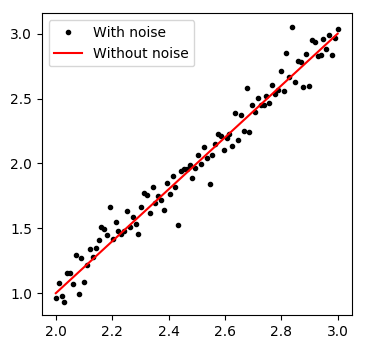

In [18]:
# Define data set
nds = 100
x = np.linspace(2, 3, num=nds)
x = x.reshape(nds,1)
m = 2 # slope
b = -3 # offset
noise = 0.1*np.random.standard_normal(x.shape)
y = m*x + b + noise

# plot data
plt.figure(dpi=100, figsize=(4,4))
plt.plot(x,y,'.k', label = 'With noise');
plt.plot(x, m*x + b, '-r', label = 'Without noise');
plt.legend();

### Define C++ Model
We define our C++ model in the file `linear_model.cpp`.
```cpp
#include <cmath>
#include <iostream>

extern "C" {
    double* linear_model(float slope, float offset, double *x, int nx) {
        double* y = new double[nx];
        for (int ii = 0; ii < nx; ii++) {
            y[ii] = slope*x[ii] + offset;
        }
        return y;
    }
}```
You must compile the code in your terminal in order to generate an object to be called within Python.  In this case, we output the compiled program to `linear_model.so`.
```bash
g++ -fPIC -shared -o linear_model.so linear_model.cpp
```
Note that `.so` is a common Linux convention for "shared object".  On macOS this might be referred to as a dynamic library (`.dylib`) and on Windows this is usually called a dynamic-link library (`.dll`).  Such objects can be inspected with the `nm` command on the macOS or Linux command line.

Within our Python script, we now utilize the `ctypes` package to make the C++ program callable within our routine.  The compiled library is loaded, and the `linear_model` is assigned to the variable `cpplm`.  The `restype` tells Python what type of variable to expect from the C++ code, and the `artypes` tells Python what data types to send to the C++ code.  For more details, see the `ctypes` documentation: https://docs.python.org/3/library/ctypes.html

In [6]:
lib = ctypes.cdll.LoadLibrary('./linear_model.so')
cpplm = lib.linear_model
cpplm.restype = ndpointer(dtype = ctypes.c_double, shape=(nds,))
cpplm.argtypes = [ctypes.c_float, ctypes.c_float, ndpointer(ctypes.c_double), ctypes.c_int]

### Define Sum-of-Squares Function
At this point we can define our sum-of-squares function and access the C++ code for model evaluation.  Note, the C++ model is inputted to the function by including it in the `user_defined_object` of the `data` structure.

In [7]:
def test_ssfun(theta, data):
    
    xdata = data.xdata[0]
    ydata = data.ydata[0]
    linear_model = data.user_defined_object[0]
    
    nx = len(xdata)
    
    # eval model c++ model
    ymodel = linear_model(theta[0], theta[1], xdata, nx)
    
    # calc sos
    ss = sum((ymodel[:] - ydata[:,0])**2)
    return ss

### Setup MCMC Simulation
We can now setup our MCMC simulation as we would for any other problem.  Note, the C++ model has been added to the `data` structure.

In [8]:
# Initialize MCMC object
mcstat = MCMC()
# Add data
mcstat.data.add_data_set(x, y, user_defined_object = cpplm)
# initialize parameter array
mcstat.parameters.add_model_parameter(name = 'm', theta0 = 1., minimum = -10, maximum = 10)
mcstat.parameters.add_model_parameter(name = 'b', theta0 = -5., minimum = -10, maximum = 100)

# update simulation options
mcstat.simulation_options.define_simulation_options(nsimu = int(10.0e3), updatesigma = 1, method = 'dram', adaptint = 100, verbosity = 1, waitbar = 1)

# update model settings
mcstat.model_settings.define_model_settings(sos_function = test_ssfun)

# Run mcmcrun
mcstat.run_simulation()


Sampling these parameters:
name         start [   min,    max] N(  mu, sigma^2)
m         :   1.00 [-10.00,  10.00] N(0.00, inf)
b         :  -5.00 [-10.00, 100.00] N(0.00, inf)


/Users/prmiles/anaconda3/envs/master_pymcmcstat/lib/python3.6/site-packages/pymcmcstat/samplers/DelayedRejection.py:189: RuntimeWarning: overflow encountered in exp
  alpha = min(np.ones(1), np.exp(y)*a2*(a1**(-1)))


 [-----------------100%-----------------] 10000 of 10000 complete in 3.9 sec

### Extract Results and Display Chain Statistics/Plots
We take the results of the MCMC simulation, remove the first half of the chain to account for burnin, and perform our analysis on the remaining part of the chain.

Plots:
- Marginal posterior densities
- Sampling chains
- Pairwise correlation


---------------------
name      :       mean        std     MC_err        tau     geweke
m         :     1.9872     0.0353     0.0021    18.1541     0.9957
b         :    -2.9805     0.0892     0.0054    18.3968     0.9926
---------------------


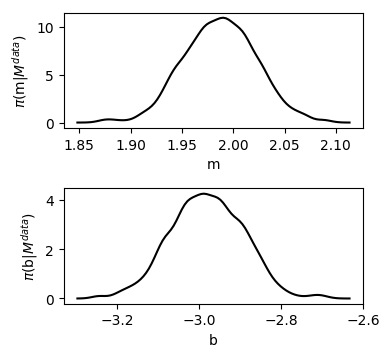

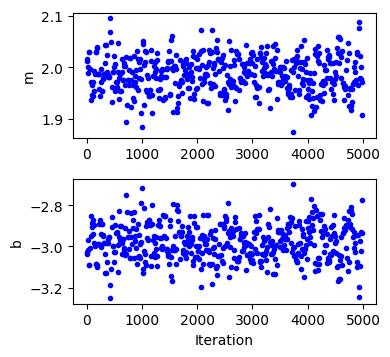

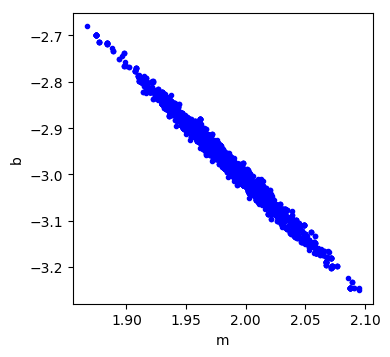

In [10]:
# Extract results
results = mcstat.simulation_results.results

chain = results['chain']
s2chain = results['s2chain']
sschain = results['sschain']

names = results['names']

# define burnin
burnin = int(results['nsimu']/2)
# display chain statistics
mcstat.chainstats(chain[burnin:,:], results)
# generate mcmc plots
mcpl = mcstat.mcmcplot # initialize plotting methods
mcpl.plot_density_panel(chain[burnin:,:], names, figsizeinches=(4,4));
mcpl.plot_chain_panel(chain[burnin:,:], names, figsizeinches=(4,4));
mcpl.plot_pairwise_correlation_panel(chain[burnin:,:], names, figsizeinches=(4,4));

### Generate/Plot Prediction Intervals
The C++ model can also be used in generating credible/prediction intervals.

Generating credible/prediction intervals:


Interval generation complete



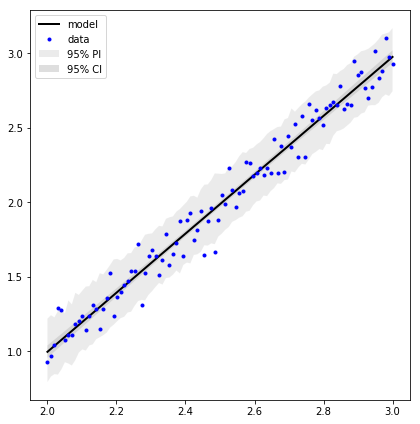

In [13]:
# generate prediction intervals
def pred_modelfun(preddata, theta):
    return cpplm(theta[0], theta[1], preddata.xdata[0], nds)
mcstat.PI.setup_prediction_interval_calculation(results = results, data = mcstat.data, modelfunction = pred_modelfun)
mcstat.PI.generate_prediction_intervals()
mcstat.PI.plot_prediction_intervals(adddata = True, figsizeinches=(6,6));